<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/u%2FEiffL%2Foptimization/nb/Optimized_HOD_HMC_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling HOD parameters by Hamiltonian Monte-Carlo

Authors:
 - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)
 - [@EiffL](https://github.com/EiffL) (Francois Lanusse)


This notebook demonstrate sampling HOD parameters using HMC over a stochastically sampled galaxy catalogs.




## Setup

Here we quickly install our dependencies, and download the reference halotools 
catalog from the Bolshoi simulation. This takes under a minute.

In [23]:
!pip install --quiet -i https://test.pypi.org/simple/ halotools
!pip install --quiet corner
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git@u/EiffL/optimization

In [ ]:
!download_initial_halocat.py

In [1]:
%pylab inline
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

In [3]:
# A few hyper parameters
temperature=0.05
batch_size=1
box_size = 250
mesh_size = 128

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

Total size of halo catalog 195126
Size of low mass halo catalog 193574
Size of high mass halo catalog 1552


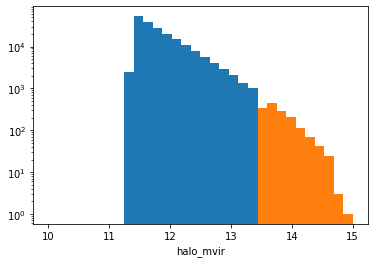

In [4]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
halo_table = halo_table[np.log10(halo_table['halo_mvir']) > 11.4] # Removing halos of too low mass

print("Total size of halo catalog", len(halo_table))

# Split the catalog into low and high mass halo
low_mass_table = halo_table[np.log10(halo_table['halo_mvir']) < 13.5]
high_mass_table = halo_table[np.log10(halo_table['halo_mvir']) >= 13.5]

# Convert table to tensors
tf_halocat_low = {k: tf.convert_to_tensor(low_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}
tf_halocat_high = {k: tf.convert_to_tensor(high_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}

hist(log10(low_mass_table['halo_mvir']),32, range=[10,15]);
hist(log10(high_mass_table['halo_mvir']),32, range=[10,15]);
yscale('log')
xlabel('halo_mvir');
print("Size of low mass halo catalog", len(low_mass_table))
print("Size of high mass halo catalog", len(high_mass_table));

In [5]:
# Here is how we define the same model in
def hod(halo_cat, logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
        max_sat=20, name='hod'):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature,
                      name=name+'_cen')
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature,
                      name=name+'_sat')
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = tf.stack([halo_cat['halo_x'],
                      halo_cat['halo_y'],
                      halo_cat['halo_z']], axis=-1)

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size),
                       name=name+'_sat_pos')
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [6]:
# def my_tracer(rv_constructor, *rv_args, **rv_kwargs):
#     rv_name = rv_kwargs.get("name")
#     rv = rv_constructor(*rv_args, **rv_kwargs)
#     print(rv_name, rv_kwargs, rv.value)
#     return rv
    
# with ed.trace(my_tracer):
#     gal_cat = hod(tf_halocat_low,
#                   logMmin=12.02*tf.ones([batch_size]),
#                   sigma_logM=0.26*tf.ones([batch_size]), 
#                   logM0=11.38*tf.ones([batch_size]), 
#                   logM1=13.31*tf.ones([batch_size]), 
#                   alpha=1.06*tf.ones([batch_size]))

In [7]:
def paint_galaxies(gal_cat, nc=mesh_size, rho=None):
  """ Function that paints galaxies on the field
  """
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  if rho is None:
    rho = tf.zeros((bs, nc, nc, nc))

  rho = cic_paint(rho,sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)
  return rho

In [8]:
# rho = paint_galaxies(hod(tf_halocat_low,
#                 logMmin=12.02*tf.ones([batch_size]),
#                 sigma_logM=0.26*tf.ones([batch_size]), 
#                 logM0=11.38*tf.ones([batch_size]), 
#                 logM1=13.31*tf.ones([batch_size]), 
#                 alpha=1.06*tf.ones([batch_size])))
# imshow(rho[0].numpy().sum(axis=0)); colorbar()

In [9]:
# rho = paint_galaxies(hod(tf_halocat_high,
#                 logMmin=12.02*tf.ones([batch_size]),
#                 sigma_logM=0.26*tf.ones([batch_size]), 
#                 logM0=11.38*tf.ones([batch_size]), 
#                 logM1=13.31*tf.ones([batch_size]), 
#                 alpha=1.06*tf.ones([batch_size]), max_sat=100))
# imshow(rho[0].numpy().sum(axis=0)); colorbar()

In [10]:
# Let's now build a function that returns a sampled power spectrum
kf = 2.*np.pi/box_size 
PS = Power_Spectrum(shape=np.array([mesh_size, mesh_size, mesh_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=kf,dk=kf)

def get_pk(logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
           max_sat_low=10, max_sat_high=100):
  """ This function samples the catalogs, paint the galaxies, and compute the 
  power spectrum
  """
  # Sample and paint galaxies low mass halos
  rho = paint_galaxies(hod(tf_halocat_low, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_low, name='low'))
  
  # Add galaxies from high mass halos
  rho = paint_galaxies(hod(tf_halocat_high, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_high, name='high'),
                       rho=rho)

  # Compute power spectrum of resulting field
  k, pk = PS.pk_tf(rho)
  return k, pk

In [11]:
# Let's just compute a diagonal cov (takes a while...)
import time
start_time = time.time()
samps = []
for i in range(100):
  k, pk = get_pk(logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))
  samps.append(pk)
end_time = time.time()- start_time
print(end_time)

Instructions for updating:
Use fn_output_signature instead
28.341368913650513


In [12]:
samps = np.stack(samps, axis=0).reshape(100,-1)
diag_std = samps.std(axis=0)
mean = samps.mean(axis=0)

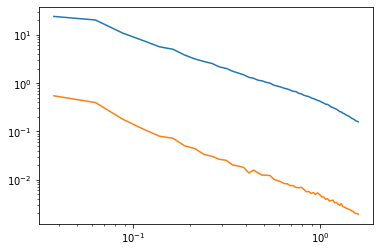

In [13]:
loglog(k,mean)
plot(k,diag_std)

In [14]:
# ok, so, now... we can write the entire model
def model_fn():
  # Define distribution for input parameters
  logMmin = ed.Normal(12.02, 0.2, name='logMmin', sample_shape=(batch_size,))
  sigma_logM = ed.Normal(0.26,0.05, name='sigma_logM', sample_shape=(batch_size,))
  logM0 = ed.Normal(11.38, 0.2, name='logM0', sample_shape=(batch_size,))
  logM1 = ed.Normal(13.31,0.5, name='logM1', sample_shape=(batch_size,))
  alpha = ed.Normal(1.06, 0.1, name='alpha', sample_shape=(batch_size,))

  # Compute power spectrum of resulting field
  _, pk = get_pk(logMmin=logMmin, sigma_logM=sigma_logM, 
                 logM0=logM0, logM1=logM1, alpha=alpha)

  # Observation likelihood
  data = ed.MultivariateNormalDiag(loc=pk, scale_identity_multiplier=0.5,
                                   name='likelihood')
  return data

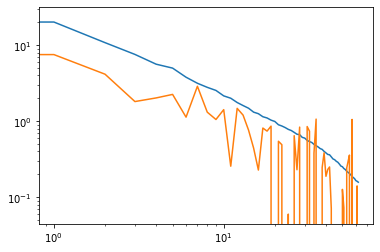

In [15]:
loglog(mean)
plot(model_fn().numpy()[0])

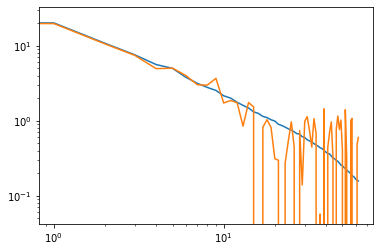

In [16]:
one = tf.ones([batch_size])
with ed.condition(sigma_logM=0.26*one, logMmin=12.02*one, logM0=11.38*one, logM1=13.31*one, alpha=1.06*one):
  loglog(mean)
  plot(model_fn().numpy()[0])

In [17]:
import tensorflow_probability as tfp 
tfd = tfp.distributions
tfb = tfp.bijectors

bij_logMmin = tfb.Shift(12.)(tfb.Scale(0.2))
bij_sigma_logM = tfb.Shift(0.26)(tfb.Scale(0.05))
bij_logM0 = tfb.Shift(11.38)(tfb.Scale(0.2))
bij_logM1 = tfb.Shift(13.31)(tfb.Scale(0.2))
bij_alpha = tfb.Shift(1.06)(tfb.Scale(0.1))

# bij_sat_low = tfb.Scale(tf.reshape(tf.convert_to_tensor(1./tf_halocat_low['halo_nfw_conc']*tf_halocat_low['halo_rvir']),
#            [1,1,-1,1]))
# bij_sat_high = tfb.Scale(tf.reshape(tf.convert_to_tensor(1./tf_halocat_high['halo_nfw_conc']*tf_halocat_high['halo_rvir']),
#            [1,1,-1,1]))

In [18]:
sample = {}
def my_tracer(rv_constructor, *rv_args, **rv_kwargs):
    rv_name = rv_kwargs.get("name")
    rv = rv_constructor(*rv_args, **rv_kwargs)
    sample[rv_name] = rv.value
    return rv
    
with ed.trace(my_tracer):
    model_fn()

In [19]:
# def target_log_prob(logMmin, sigma_logM, 
#                     logM0, logM1, alpha, *args
#                     low_cen_Logistic, low_sat_Logistic, low_sat_pos,
#                     high_cen_Logistic, high_sat_Logistic, high_sat_pos):
#   logMmin = bij_logMmin(logMmin)
#   sigma_logM = bij_sigma_logM(sigma_logM)
#   logM0 = bij_logM0(logM0)
#   logM1 = bij_logM1(logM1)
#   alpha = bij_alpha(alpha)
#   low_sat_pos = bij_sat_low(low_sat_pos)
#   high_sat_pos = bij_sat_high(high_sat_pos)   
    
#   return log_joint(batch_size=1, logMmin=logMmin, sigma_logM=sigma_logM, 
#                     logM0=logM0, logM1=logM1, alpha=alpha,
#                     low_cen_Logistic=low_cen_Logistic, low_sat_Logistic= low_sat_Logistic,
#                     low_sat_pos=low_sat_pos,
#                     high_cen_Logistic=high_cen_Logistic, 
#                     high_sat_Logistic=high_sat_Logistic, 
#                     high_sat_pos=high_sat_pos,
#                    likelihood=mean)
log_joint = ed.make_log_joint_fn(model_fn)

def target_log_prob(logMmin, sigma_logM, 
                    logM0, logM1, alpha, 
                   low_cen_Logistic, low_sat_Logistic, high_cen_Logistic, high_sat_Logistic):
  logMmin = bij_logMmin(logMmin)
  sigma_logM = bij_sigma_logM(sigma_logM)
  logM0 = bij_logM0(logM0)
  logM1 = bij_logM1(logM1)
  alpha = bij_alpha(alpha)

  log_prob = log_joint(logMmin=logMmin, sigma_logM=sigma_logM, 
                    logM0=logM0, logM1=logM1, alpha=alpha,
                    low_cen_Logistic=low_cen_Logistic, low_sat_Logistic= low_sat_Logistic,
                    low_sat_pos=sample['low_sat_pos'],
                    high_cen_Logistic=high_cen_Logistic, 
                    high_sat_Logistic=high_sat_Logistic, 
                    high_sat_pos=sample['high_sat_pos'],
                    likelihood=mean)

  # adding boundary condition for nfw profiles
  # r_low = tf.norm(low_sat_pos, axis=-1) 
  # r_high = tf.norm(high_sat_pos, axis=-1) 
  return log_prob #- tf.reduce_sum(tf.clip_by_value(tf.exp(r_low*3) -tf.exp(3.), 0, 100)) - tf.reduce_sum(tf.clip_by_value(tf.exp(r_high*3) -tf.exp(3.), 0, 100)) 

In [20]:
init_state = [sample['logMmin']*0+tf.random.normal(sample['logMmin'].shape), 
              sample['sigma_logM']*0+tf.random.normal(sample['sigma_logM'].shape), 
              sample['logM0']*0+tf.random.normal(sample['logM0'].shape), 
              sample['logM1']*0+tf.random.normal(sample['logM1'].shape), 
              sample['alpha']*0+tf.random.normal(sample['alpha'].shape),
              sample['low_cen_Logistic'], 
              sample['low_sat_Logistic'], 
              sample['high_cen_Logistic'], 
              sample['high_sat_Logistic']]

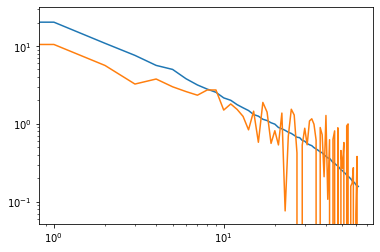

In [21]:
def test(logMmin, sigma_logM, 
                    logM0, logM1, alpha,
                    low_cen_Logistic, low_sat_Logistic, 
                    high_cen_Logistic, high_sat_Logistic):
  logMmin = bij_logMmin(logMmin)
  sigma_logM = bij_sigma_logM(sigma_logM)
  logM0 = bij_logM0(logM0)
  logM1 = bij_logM1(logM1)
  alpha = bij_alpha(alpha) 
    
  with ed.condition(logMmin=logMmin, sigma_logM=sigma_logM, 
                    logM0=logM0, logM1=logM1, alpha=alpha,
                    low_cen_Logistic=low_cen_Logistic, low_sat_Logistic= low_sat_Logistic,
                    high_cen_Logistic=high_cen_Logistic, 
                    high_sat_Logistic=high_sat_Logistic, ):
    return model_fn().numpy()[0]

loglog(mean)
plot(test(*init_state))

In [22]:
# Initialize the HMC transition kernel.
num_results = int(1e2)
#num_burnin_steps = int(1e2)
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob,
        num_leapfrog_steps=10,
        step_size=0.03)

In [23]:
# Run the chain (with burn-in).
@tf.function
def run_chain(state, kernel_result=None):
  # Run the chain (with burn-in).
  samples, is_accepted, kernel_result = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=state,
      previous_kernel_results=kernel_result,
      kernel=adaptive_hmc,
      return_final_kernel_results=True,
      trace_fn=lambda _, pkr: pkr.is_accepted)
  return samples, is_accepted, kernel_result

In [24]:
results = []

In [25]:
import time
t = time.time()
res, tra, kr = run_chain(init_state)
results.append([res[i][tra].numpy() for i in range(5)])
print(time.time() - t)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
78.88696503639221


In [51]:
# Running the chain, that's more or less half an hour
for i in range(30):
    print("iter",i)
    res, tra, kr = run_chain([res[i][-1] for i in range(len(res))], kr)
    results.append([res[i][tra].numpy() for i in range(5)])
    print('got %d samples'%(tra.numpy().sum()))

iter 0
got 70 samples
iter 1
got 76 samples
iter 2
got 79 samples
iter 3
got 79 samples
iter 4
got 67 samples
iter 5
got 75 samples
iter 6
got 78 samples
iter 7
got 83 samples
iter 8
got 75 samples
iter 9
got 82 samples
iter 10
got 80 samples
iter 11
got 71 samples
iter 12
got 67 samples
iter 13
got 83 samples
iter 14
got 66 samples
iter 15
got 70 samples
iter 16
got 77 samples
iter 17
got 69 samples
iter 18
got 75 samples
iter 19
got 70 samples
iter 20
got 80 samples
iter 21
got 76 samples
iter 22
got 76 samples
iter 23
got 67 samples
iter 24
got 77 samples
iter 25
got 70 samples
iter 26
got 65 samples
iter 27
got 75 samples
iter 28
got 77 samples
iter 29
got 67 samples


In [52]:
r = np.concatenate([np.stack(i, axis=-1) for i in results],axis=0).squeeze()

In [53]:
r.shape

(3740, 5)

In [54]:
tfp.mcmc.effective_sample_size(r)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 69.44782, 107.82274,  59.73095,  59.83656,  78.92011],
      dtype=float32)>

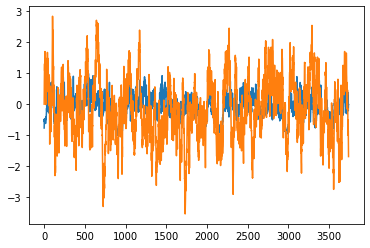

In [55]:
plot(r[:,0])
plot(r[:,1])

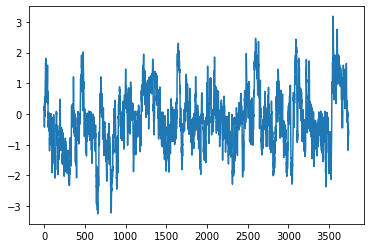

In [56]:
plot(r[:,2])

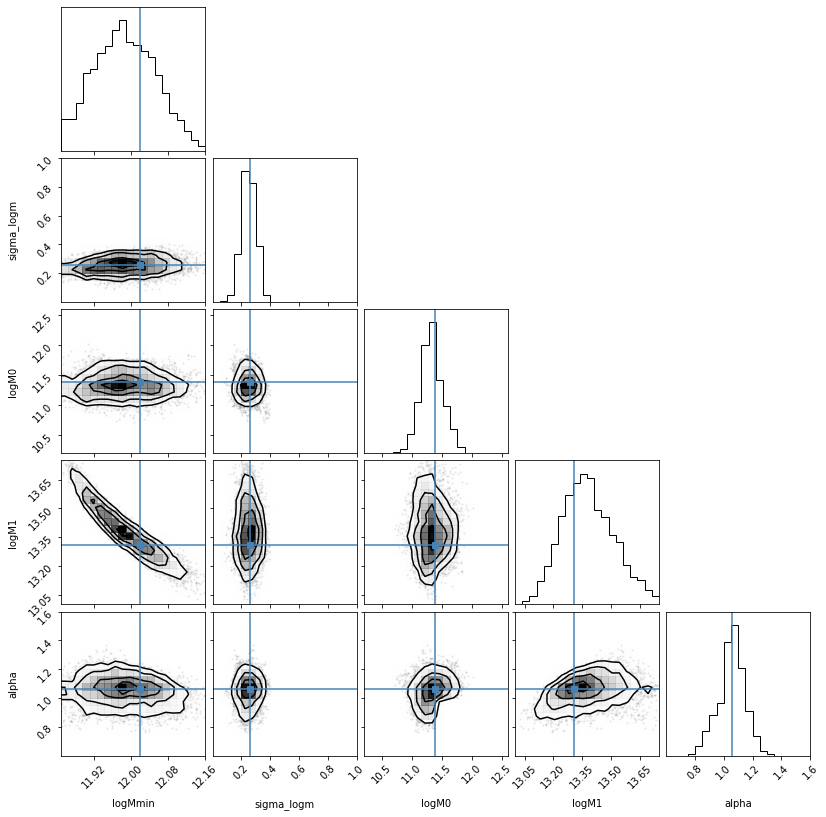

In [57]:
import corner
burn_in=10
corner.corner(np.array([ bij_logMmin(r[burn_in:,0]), 
                         bij_sigma_logM(r[burn_in:,1]),
                         bij_logM0(r[burn_in:,2]), 
                         bij_logM1(r[burn_in:,3]),
                         bij_alpha(r[burn_in:,4]),                                              
                       ]).T.reshape([-1,5]),
              truths=[12.02,0.26, 11.38, 13.31, 1.06],
              smooth=0.5,
             range=[[11.85, 12.16], [0., 1.], [10.2, 12.6 ], [13., 13.75], [0.6, 1.6]],
             labels=['logMmin', 'sigma_logm', 'logM0', 'logM1', 'alpha']);